In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

In [74]:
# Simulation parameters
nsim = 100  # Number of simulations
nobs = 100  # Number of observations in each simulation
p = 10      # Number of predictors
beta = np.array([2, 3] + [0] * (p - 2))  # Coefficients: β1=2, β2=3, others=0

x0 = np.full(p, 2)  # Out-of-sample observation
# Prepare x0 for prediction (add constant and reshape for prediction)
x0 = np.insert(x0, 0, 1)  # Füge die `1` für den Intercept am Anfang ein
x0 = x0.reshape(1, -1)  # Umschreiben x0 in ein 2D-Array für die Vorhersage


In [75]:
OLS = {"prediction":[], "coefficient":[]}
LASSO = {"prediction":[], "coefficient":[], "alpha":[]}
RIDGE = {"prediction":[], "coefficient":[], "alpha":[]}

In [76]:

# Mittelwertvektor und Kovarianzmatrix erstellen
mu = np.zeros(p)  # Erzeugt einen Vektor mit Nullen der Länge p
Sigma = np.eye(p)  # Erzeugt eine p x p Einheitsmatrix


# Function to simulate data
def simulate_data(nobs, p, beta):
    X = np.random.multivariate_normal(mu, Sigma, nobs)
    noise = np.random.normal(0, 1, nobs)
    y = X @ beta + noise
    return X, y

for _ in range(0,nsim):
    X_example, y_example = simulate_data(nobs, p, beta)
    X_example = sm.add_constant(X_example)  # Füge eine Konstantenspalte hinzu
    fitOLS = sm.OLS(y_example,X_example)
    model = fitOLS.fit()
    prediction = model.predict(x0)
    OLS["prediction"].append(prediction)
    OLS["coefficient"].append(model.params)

    fitLASSO = LassoCV(cv=5, random_state=42).fit(X_example,y_example)
    prediction = fitLASSO.predict(x0)
    LASSO["prediction"].append(prediction)
    LASSO["coefficient"].append(fitLASSO.coef_)
    LASSO["alpha"].append(fitLASSO.alpha_)

    fitRidge = RidgeCV(cv=5).fit(X_example,y_example)
    prediction = fitRidge.predict(x0)
    RIDGE["prediction"].append(prediction)
    RIDGE["coefficient"].append(fitRidge.coef_)
    RIDGE["alpha"].append(fitRidge.alpha_)


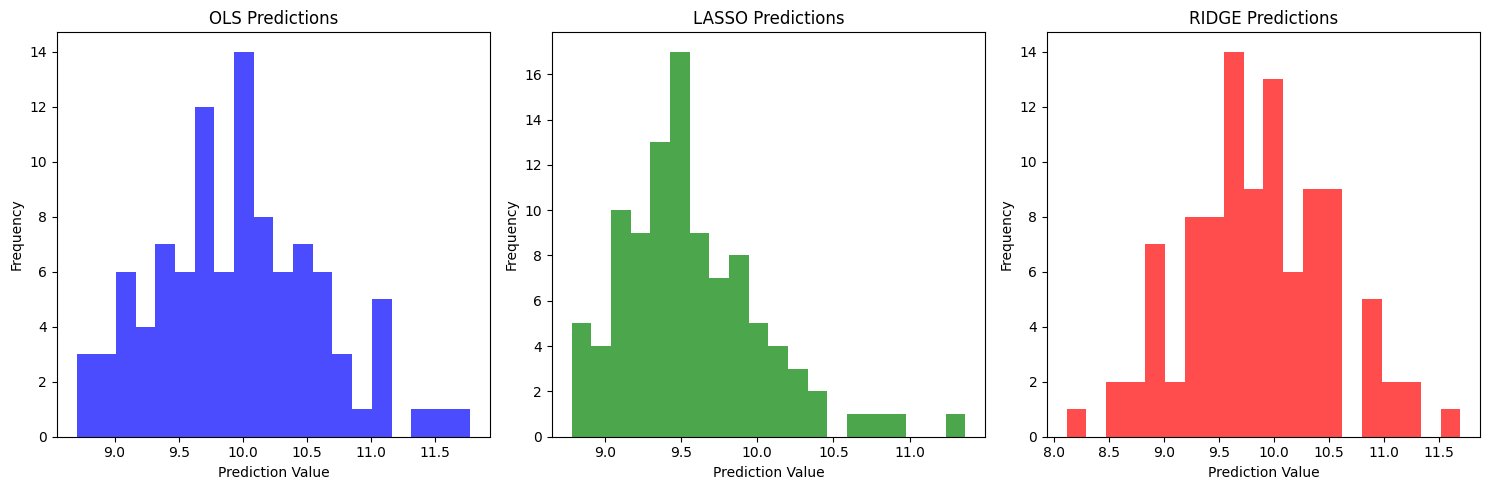

In [77]:
# Flache Arrays erstellen durch Verketten der verschachtelten Arrays
OLS["prediction"] = np.concatenate(OLS['prediction'])
LASSO['prediction'] = np.concatenate(LASSO['prediction'])
RIDGE['prediction'] = np.concatenate(RIDGE['prediction'])

# Erstellen der Histogramme
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Histogramm für OLS
axes[0].hist(OLS["prediction"], bins=20, color='blue', alpha=0.7)
axes[0].set_title('OLS Predictions')
axes[0].set_xlabel('Prediction Value')
axes[0].set_ylabel('Frequency')

# Histogramm für LASSO
axes[1].hist(LASSO['prediction'], bins=20, color='green', alpha=0.7)
axes[1].set_title('LASSO Predictions')
axes[1].set_xlabel('Prediction Value')
axes[1].set_ylabel('Frequency')

# Histogramm für RIDGE
axes[2].hist(RIDGE['prediction'], bins=20, color='red', alpha=0.7)
axes[2].set_title('RIDGE Predictions')
axes[2].set_xlabel('Prediction Value')
axes[2].set_ylabel('Frequency')

# Anzeige des Plots
plt.tight_layout()
plt.show()

In [ ]:
4. How do bias and variance depend on the number of irrelevant regressors?
5. How do bias and variance depend on the number of observations?



4. How do bias and variance depend on the number of irrelevant regressors?
5. How do bias and variance depend on the number of observations?

4. Bei OLS wirken diese sich negativ aus, da eine Regulierung angepasst wird. 
Im Vergleich sichtbar

5. Diese haengen davon ab. Gibt es mehr Daten, kann das Modell besser generalisieren, 